## Objective:

**To apply Agglomerative clustering on Amazon Food Reviews**

Agglomerative Clustering is an example of Hierarchical clustering. It is an unsupervised learning method. It's drawback is that it has a very high time and space complexity so it's not feasible for datasets where the number of dimensions is extremely high like in case of BoW\Tfidf. But for the sake of completion, I'll try it on all the vector formats -

* Bag of Words (BoW)
* Term frequency inverse document frequency (Tfidf)
* Avg. Word to Vector (W2V)
* Tfidf weighted W2V

I'll also create wordclouds from few sample reviews belonging to each cluster. I'll however not visualize the clusters through a graph, because as you will see ahead, the number of dimensions for each data point is HUGE! reducing them to 2-3 for visualization will result in significant loss of information, which will seriously limit the clustering capabilities of our model.

In [1]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.sparse import vstack
from sklearn.model_selection import GridSearchCV
import sqlite3
from scipy.sparse import issparse
from wordcloud import WordCloud

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

**Some functions**

* *plot_wordcloud* : As the name says, it will create wordclouds from n sample reviews belonging to each cluster
* *get_random_positive_negative_reviews* : It will fetch from the dataset (n/2) positive and negative reviwes shuffled randomly
* *cluster_distribution* : It determines how many reviews are present in each cluster

In [3]:
def plot_wordcloud(prediction_array, df_reviews_clean, n):
    """
        Display K wordclouds for a certain value of K(#clusters) created using
        n sample reviews belonging to each cluster 
    """
    samples = []

    for cluster_no in np.unique(prediction_array):

        ix = np.where(prediction_array == cluster_no)
        
        samples.append(df_reviews_clean.iloc[ix]['cleaned_text'].head(n))
    
    
    plt.figure(figsize=(15,7))
    plt.style.use('bmh')
    
    for cluster_no in np.unique(prediction_array):
        
        big_review = ' '
        
        for review in list(samples[cluster_no]):
            
            big_review = big_review + review.decode('utf-8')
                    
        plt.subplot(2,4,cluster_no+1)
        wc = WordCloud(width=1500, height=1500).generate(big_review)
        _ = plt.imshow(wc, interpolation='bilinear')
        _ = plt.title('Cluster {}'.format(cluster_no))
        _ = plt.axis("off")

    
    _ = plt.show()
    _ = plt.tight_layout(pad=0)
    
    return samples

In [4]:
def get_random_positive_negative_reviews(X, y, n = 100):
    
    X_positive = X[y == 1]
    X_negative = X[y == 0]
    X_positive = X_positive[np.random.randint(X_positive.shape[0], size=n), :]
    X_negative = X_negative[np.random.randint(X_negative.shape[0], size=n), :]
    
    if issparse(X):
        X_pn = np.vstack([X_positive.toarray(), X_negative.toarray()])
    else:
        X_pn = np.vstack([X_positive, X_negative])
        
    np.random.shuffle(X_pn)
    
    return X_pn

In [5]:
def cluster_distribution(predictions):
    
    for cluster_no in range(len(predictions)):
    
        cluster_bincounts = np.bincount(predictions[cluster_no])
        print('cluster k={} : {}'.format(len(cluster_bincounts), cluster_bincounts))

Also, load the cleaned reviews stored on the disk. We'll need them to collect samples belonging to each cluster 

In [6]:
con = sqlite3.connect('/home/ucanreachtvk/data/reviews_cleaned_final.sqlite')
# con = sqlite3.connect(r'C:\Users\ucanr\Downloads\reviews_cleaned_final.sqlite')
df_reviews_clean = pd.read_sql('select cleaned_text from Reviews;', con)

In [7]:
len(df_reviews_clean)

364171

### Load y

In [8]:
# f = open(r'D:\data_science\datasets\amazon2\y_train_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_train_full80_20.pkl', 'rb')
y_train = pickle.load(f)
f.close()
print('The datatype of y_train is : {}'.format(type(y_train)))
print('The shape of y_train is : {}'.format(y_train.shape))

The datatype of y_train is : <class 'numpy.ndarray'>
The shape of y_train is : (291336,)


## Bag of Words

Load the data.

In [9]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_bow_full_nparray.pkl', 'rb')
X_train_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_bow is : {}'.format(type(X_train_transformed_bow)))
print('The shape of X_train_transformed_bow is : {}'.format(X_train_transformed_bow.shape))

The datatype of X_train_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_bow is : (291336, 64221)


Take 5000 reviews - 2500 positive and 2500 negative.

In [10]:
X_bow = get_random_positive_negative_reviews(X_train_transformed_bow, y_train, n = 2500)

In [11]:
X_bow.shape

(5000, 64221)

**Standardize data**

In [ ]:
scaler = StandardScaler(with_mean=True)
X_bow_std = scaler.fit_transform(X_bow)

**Agglomerative Clustering | BoW**

In [13]:
%%notify
%%time

predictions = []

for k in [2,3,4,5,6,7,8]:
    aggclu = AgglomerativeClustering(n_clusters=k)
    predictions.append(aggclu.fit_predict(X_bow_std))
    print('done k:= {} '.format(k), end= '|')

done k:= 2 |done k:= 3 |done k:= 4 |done k:= 5 |done k:= 6 |done k:= 7 |done k:= 8 |CPU times: user 2h 23min 4s, sys: 8.23 s, total: 2h 23min 13s
Wall time: 2h 24min 28s


<IPython.core.display.Javascript object>

**Cluster Distribution | BoW**

See how the reviews are distributed in each of the clusters for various values of K. The following function gives you the number of reviews in each cluster for various values of k.

In [14]:
cluster_distribution(predictions)

cluster k=2 : [4998    2]
cluster k=3 : [4997    2    1]
cluster k=4 : [4996    2    1    1]
cluster k=5 : [   2 4994    1    1    2]
cluster k=6 : [4994    2    1    1    1    1]
cluster k=7 : [4993    2    1    1    1    1    1]
cluster k=8 : [   9 4984    1    2    1    1    1    1]


** WordClouds | BoW**

There is a lot of polarization in the clusters as can be seen above. i.e. most of the reviews are present in a single cluster while the others are almost empty. In such a scenario, it's doesn't make sense to find any pattern in the clusters. 
The same problem occurs with Tfidf as well.

However, as you can see above, for k=8 cluster #1 has almost all the data points(4984). If we observe its wordcloud below, we notice that the words 'taste', 'flavor', 'chip' etc. are found most frequently.

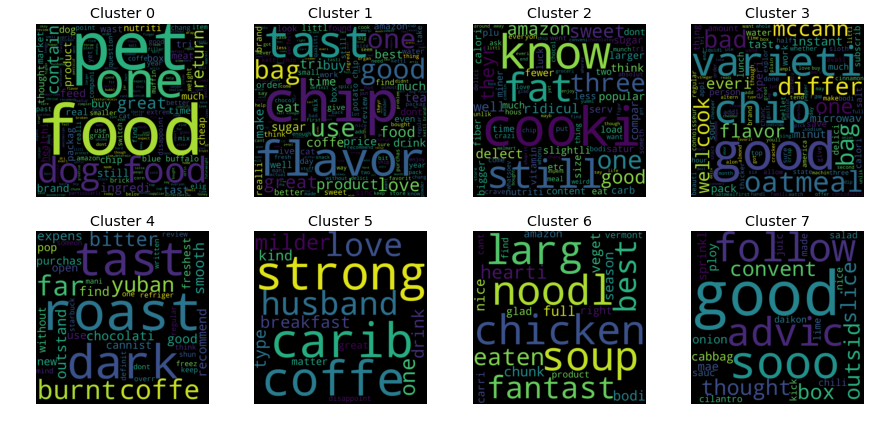

<Figure size 432x288 with 0 Axes>

In [15]:
_ = plot_wordcloud(predictions[6], df_reviews_clean, n=500)

### Tfidf

Load the data.

In [9]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_tfidf_full_nparray.pkl', 'rb')
X_train_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_tfidf is : {}'.format(type(X_train_transformed_tfidf)))
print('The shape of X_train_transformed_tfidf is : {}'.format(X_train_transformed_tfidf.shape))

The datatype of X_train_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_tfidf is : (291336, 64221)


In [10]:
X_tfidf = get_random_positive_negative_reviews(X_train_transformed_tfidf, y_train, n = 2500)

**Standardize data**

In [11]:
scaler = StandardScaler(with_mean=True)
X_tfidf_std = scaler.fit_transform(X_tfidf)

In [12]:
%%notify
%%time

predictions = []

for k in [2,3,4,5,6,7,8]:
    aggclu = AgglomerativeClustering(n_clusters=k)
    predictions.append(aggclu.fit_predict(X_tfidf_std))
    print('done k:= {} '.format(k), end='|')

done k:= 2 |done k:= 3 |done k:= 4 |done k:= 5 |done k:= 6 |done k:= 7 |done k:= 8 |CPU times: user 1h 57min 52s, sys: 2.39 s, total: 1h 57min 55s
Wall time: 1h 57min 55s


<IPython.core.display.Javascript object>

**Cluster Distribution | Tfidf**

The polarization is even worse in case of Tfidf. For all values of k, barring one cluster, all the others have just one data point.

In [13]:
cluster_distribution(predictions)

cluster k=2 : [4999    1]
cluster k=3 : [4998    1    1]
cluster k=4 : [4997    1    1    1]
cluster k=5 : [4996    1    1    1    1]
cluster k=6 : [4995    1    1    1    1    1]
cluster k=7 : [4994    1    1    1    1    1    1]
cluster k=8 : [4993    1    1    1    1    1    1    1]


**WordCloud | Tfidf**

For k=8, cluster #0 contains the words 'chip', 'taste', 'flavor' most frequently.

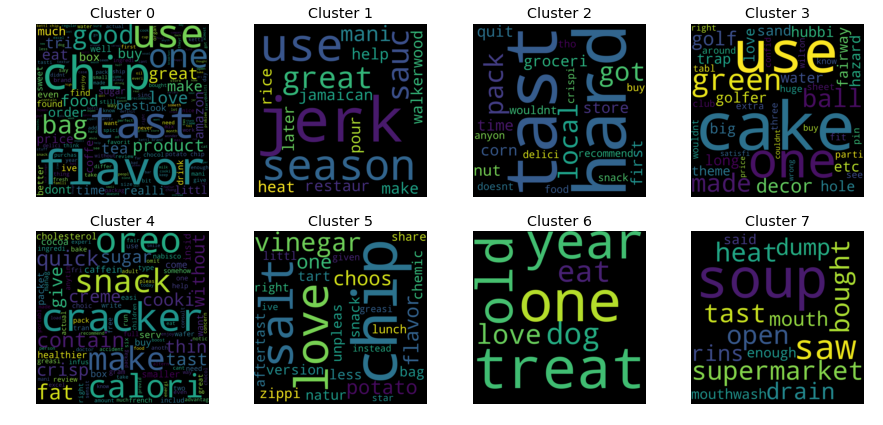

<Figure size 432x288 with 0 Axes>

In [14]:
_ = plot_wordcloud(predictions[6], df_reviews_clean, n=1000)

## Avg. W2V

Load the data

In [15]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_avgW2V is : {}'.format(type(X_train_transformed_avgW2V)))
print('The shape of X_train_transformed_avgW2V is : {}'.format(X_train_transformed_avgW2V.shape))

The datatype of X_train_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_avgW2V is : (291336, 50)


In [16]:
X_w2v = get_random_positive_negative_reviews(X_train_transformed_avgW2V, y_train, n = 2500)

**Standardize data**

In [17]:
scaler = StandardScaler(with_mean=True)
X_w2v_std = scaler.fit_transform(X_w2v)

In [18]:
%%notify
%%time

predictions = []

for k in [2,3,4,5,6,7,8]:
    aggclu = AgglomerativeClustering(n_clusters=k)
    predictions.append(aggclu.fit_predict(X_w2v_std))
    print('done k:= {} '.format(k), end='|')

done k:= 2 |done k:= 3 |done k:= 4 |done k:= 5 |done k:= 6 |done k:= 7 |done k:= 8 |CPU times: user 9.13 s, sys: 740 ms, total: 9.87 s
Wall time: 9.86 s


<IPython.core.display.Javascript object>

**Cluster distribution | Avg. W2V**

Here, the reviews are better spread. All clusters have significant number of reviews in them.

In [19]:
cluster_distribution(predictions)

cluster k=2 : [ 676 4324]
cluster k=3 : [4324  125  551]
cluster k=4 : [ 125 4035  551  289]
cluster k=5 : [4035    3  551  289  122]
cluster k=6 : [ 551    3 2783  289  122 1252]
cluster k=7 : [   3  464 2783  289  122 1252   87]
cluster k=8 : [ 464  122 2783  289    2 1252   87    1]


**WordCloud | Avg. W2V**

Looking at the wordcloud for k=8, the words 'flavor', 'taste' etc are present in almost all of them.

But there are some subtle differences like 'Coffee' is found mostly in cluster #6, 'chip' is found mostly in cluster #2.

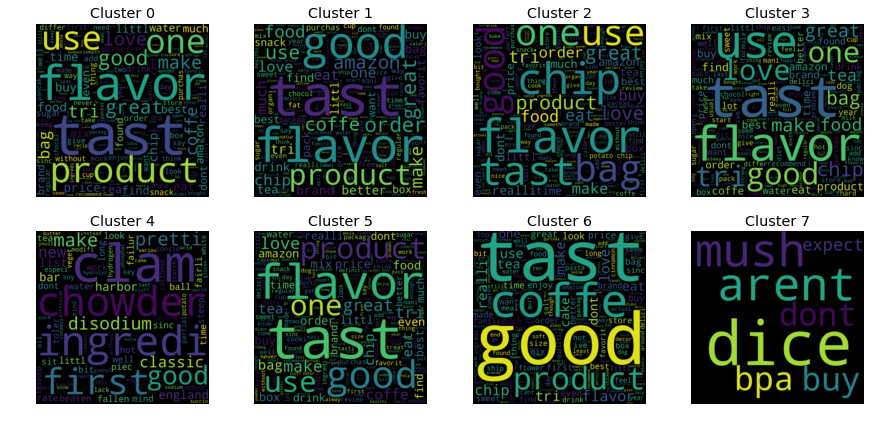

<Figure size 432x288 with 0 Axes>

In [20]:
_ = plot_wordcloud(predictions[6], df_reviews_clean, n=1000)

## Tfidf wt. W2V

In [21]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_TfidfW2V is : {}'.format(type(X_train_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_train_transformed_TfidfW2V.shape))

The datatype of X_train_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (291336, 50)


In [22]:
X_tfidfw2v = get_random_positive_negative_reviews(X_train_transformed_TfidfW2V, y_train, n = 2500)

**Standardize data**

In [23]:
scaler = StandardScaler(with_mean=True)
X_tfidfw2v_std = scaler.fit_transform(X_tfidfw2v)

Apply Agglomerative Clustering on this data

In [24]:
%%notify
%%time

predictions = []

for k in [2,3,4,5,6,7,8]:
    aggclu = AgglomerativeClustering(n_clusters=k)
    predictions.append(aggclu.fit_predict(X_tfidfw2v_std))
    print('done k:= {} '.format(k), end='|')

done k:= 2 |done k:= 3 |done k:= 4 |done k:= 5 |done k:= 6 |done k:= 7 |done k:= 8 |CPU times: user 9.62 s, sys: 1.05 s, total: 10.7 s
Wall time: 10.7 s


<IPython.core.display.Javascript object>

**Cluster Distribution | Tfidf wt. W2V**

In [25]:
cluster_distribution(predictions)

cluster k=2 : [4465  535]
cluster k=3 : [4079  535  386]
cluster k=4 : [3257  535  386  822]
cluster k=5 : [1242  535  386  822 2015]
cluster k=6 : [ 535 2015  556  822  686  386]
cluster k=7 : [2015  822  556  256  686  386  279]
cluster k=8 : [ 704 1311  556  822  686  386  279  256]


**WordCloud | Tfidf wt. W2V**

Here, although the clusters are more evenly populated, most of the frequent words are found in all of the clusters.

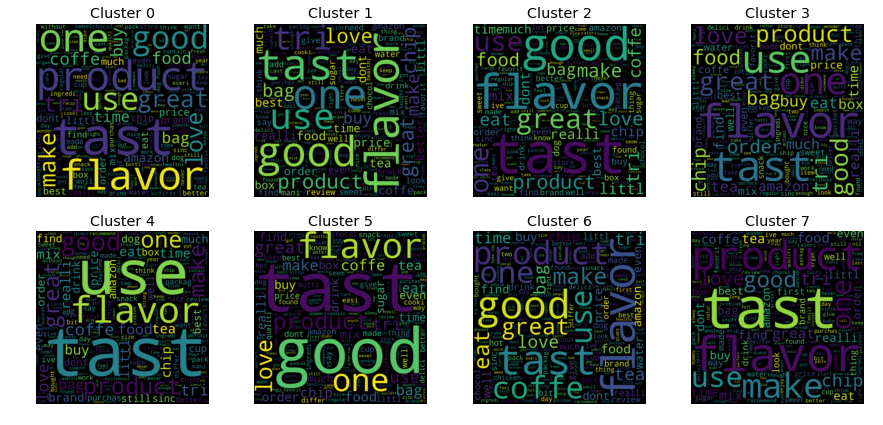

<Figure size 432x288 with 0 Axes>

In [26]:
_ = plot_wordcloud(predictions[6], df_reviews_clean, n=1000)

## Conclusion:

* Applied Agglomerative Clustering on a random sample of Amazon food reviews
* Analyzed how the clusters are populated for various values of K
* Observed sample reviews from each cluster for a given K